# Decoded Quantum Interferometry Algorithm - Qiskit Implementation with Belief Propagation

This notebook demonstrates the DQI algorithm using Qiskit with Belief Propagation (BP) decoding.

In [164]:
import os, sys

# if this notebook is in notebooks/, go up one level then into src/
root = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.insert(0, root)

import numpy as np
import warnings
import pprint
pp = pprint.PrettyPrinter(depth=4)

# Qiskit imports for simulation and circuit construction
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, partial_trace

# Custom module imports - updated to use new structure
from dqi.qiskit.initialization.state_preparation.gates import UnaryAmplitudeEncoding
from dqi.qiskit.initialization.calculate_w import get_optimal_w

from dqi.qiskit.dicke_state_preparation.gates import UnkGate

from dqi.qiskit.decoding.gates import GJEGate
from dqi.qiskit.decoding.BPQM.linearcode import LinearCode
from dqi.qiskit.decoding.BPQM.decoders import create_init_qc, decode_single_syndrome
from dqi.qiskit.decoding.BPQM.cloner import VarNodeCloner

from dqi.utils.graph import get_max_xorsat_matrix, find_graph_with_target_max_solutions
from dqi.utils.solver import brute_force_max
from dqi.utils.visualize import draw_graph, plot_results_union_plotly
from dqi.utils.counts import post_selection_counts, combine_counts

warnings.filterwarnings("ignore")

## Brute-Force Objective Landscape Visualization

Compute the brute-force objective values for every assignment and visualize the resulting landscape.
This plot will later be compared with the simulation data.


In [165]:
H = np.array([
        [1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 1, 1]
    ]).T

B = H.T
v = np.ones(B.shape[0])
v

array([1., 1., 1., 1., 1., 1.])

In [166]:
brute_force_results = brute_force_max(B, v)
plot_results_union_plotly(
    brute_force_results,
    {},
    plot_name="Objective Values Landscape",
    spline_smoothing=1.3
)


In [167]:
n = len(B[0])  # Number of qubits corresponding to constraints
m, p, r, ell = len(B), 2, 1, 2  # Additional parameters for state preparation

# Compute optimal weight values for the initialization
w = get_optimal_w(m, ell, p, r)
 
print("Optimal W_k value: ", w.tolist())

Optimal W_k value:  [0.4330127018922193, 0.7071067811865475, 0.5590169943749475, 0.0]


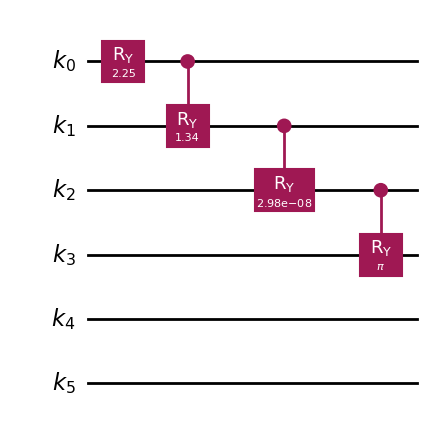

In [168]:
# Build the initialization circuit using Weighted Unary Encoding
init_qregs = QuantumRegister(m, name='k')
initialize_circuit = QuantumCircuit(init_qregs)
WUE_Gate = UnaryAmplitudeEncoding(num_bit=m, weights=w)
initialize_circuit.append(WUE_Gate, range(m))
display(initialize_circuit.decompose().draw('mpl'))
show_sv = False
if show_sv:
    display(Statevector(initialize_circuit).draw('latex'))


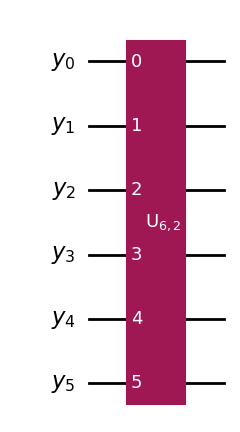

In [169]:
# Prepare the Dicke state circuit
dicke_qregs = QuantumRegister(m, name='y')
dicke_circuit = QuantumCircuit(dicke_qregs)
max_errors = int(np.nonzero(w)[0][-1]) if np.any(w) else 0
dicke_circuit.append(UnkGate(m, max_errors), range(m))
display(dicke_circuit.draw('mpl'))

In [170]:
theta = 0.2 * np.pi
cloner = VarNodeCloner(theta)
code = LinearCode(None, H)
syndrome_qc = QuantumCircuit(code.hk)

decoded_bits, decoded_qubits, qc_decode = decode_single_syndrome(
    syndrome_qc=syndrome_qc,
    code=code,
    prior=0.5,
    theta=theta,
    height=2,
    shots=1024,
    debug=True,
    run_simulation=False
)

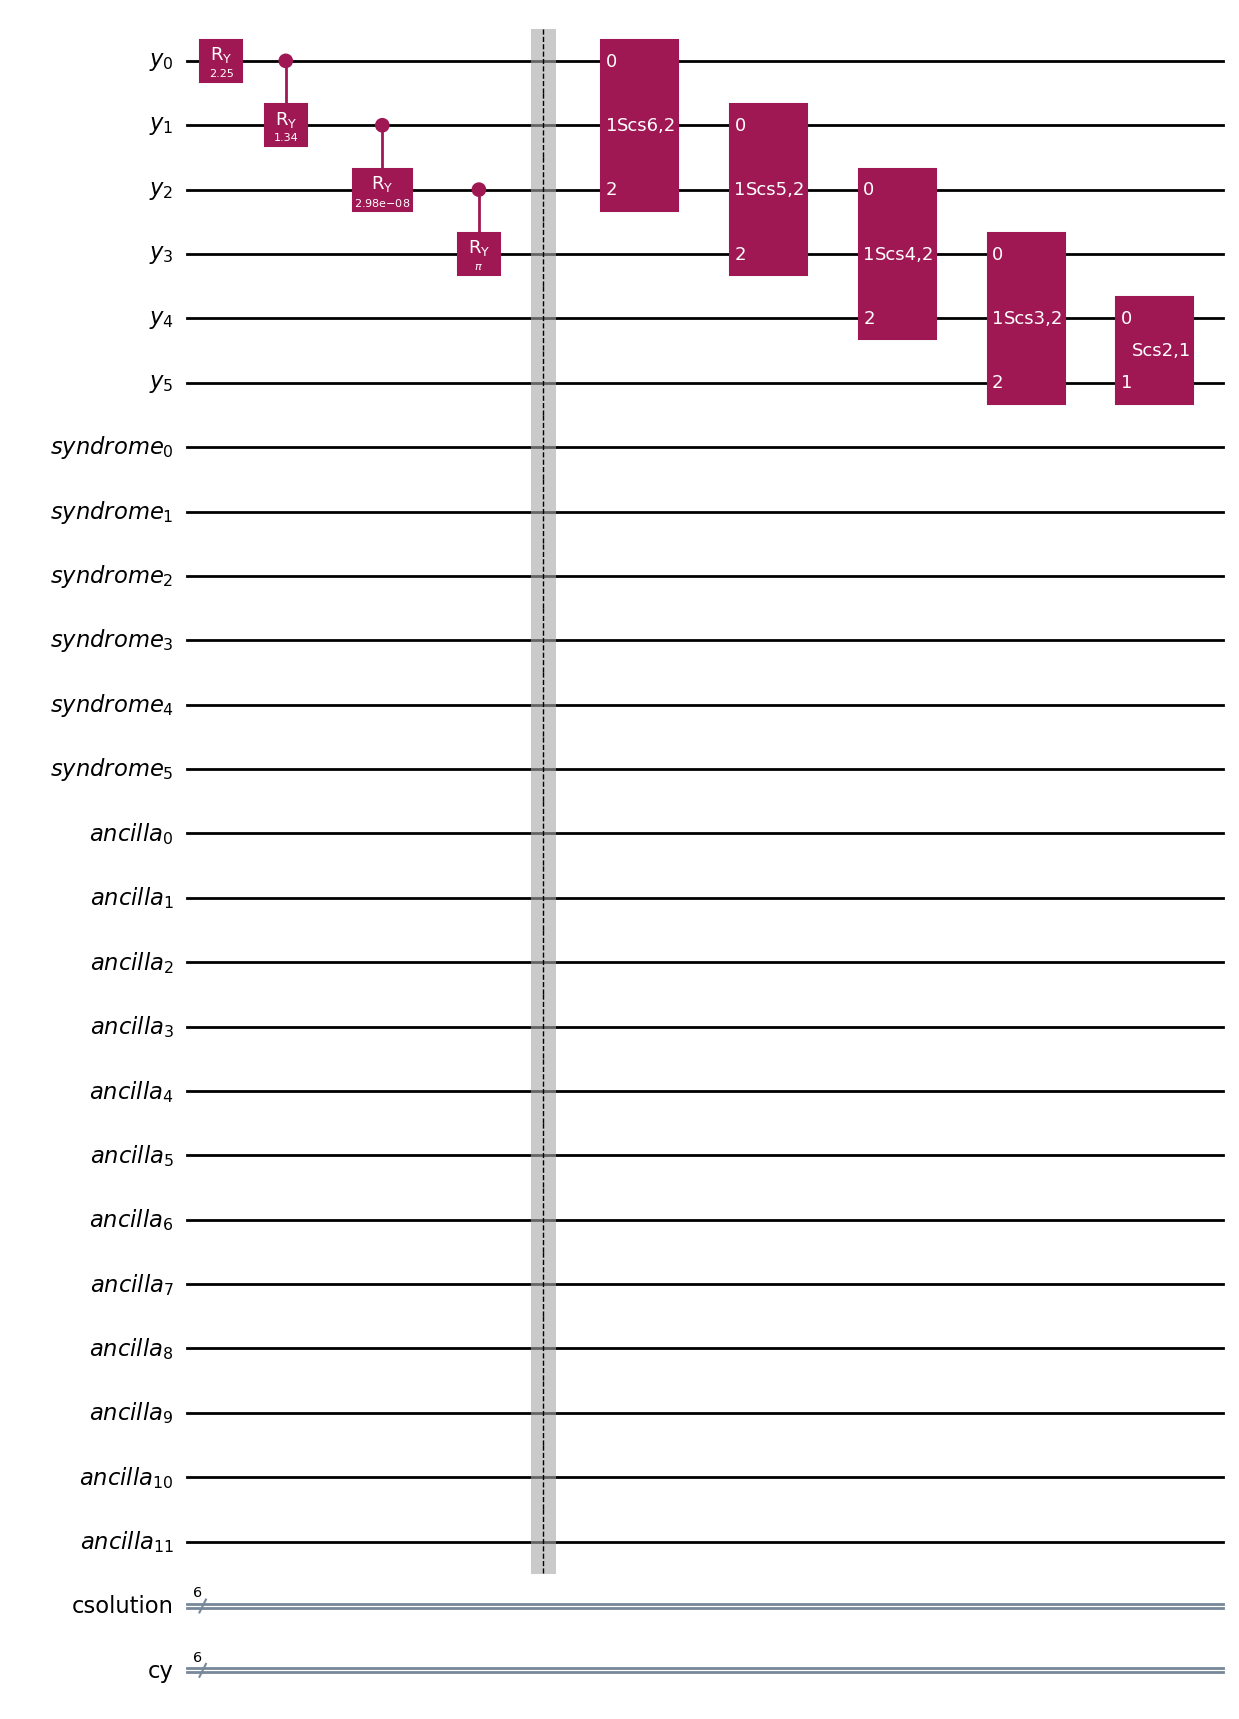

In [171]:
# Create registers for syndrome and measurement
dicke_qregs = QuantumRegister(m, name='y') 
dicke_cregs = ClassicalRegister(m, name='cy')
syndrome_qregs = QuantumRegister(n, name='syndrome')
syndrome_cregs = ClassicalRegister(syndrome_qregs.size, name='csolution')
ancilla_qregs =  QuantumRegister(qc_decode.num_qubits - m, name='ancilla')
# Build the DQI circuit by composing initialization and Dicke circuits
dqi_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs, syndrome_cregs, dicke_cregs, ancilla_qregs)
dqi_circuit.compose(initialize_circuit, inplace=True)
dqi_circuit.barrier()
dqi_circuit.compose(dicke_circuit, inplace=True)
display(dqi_circuit.decompose().draw('mpl'))
if show_sv:
    display(Statevector(dqi_circuit).draw('latex'))

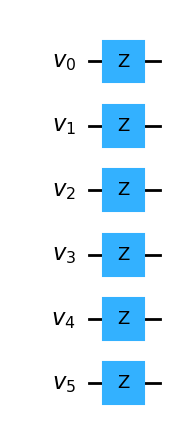

In [172]:
# Apply phase flip operations based on v
v_phase_qregs = QuantumRegister(m, name='v')
v_phase_flip_circuit = QuantumCircuit(v_phase_qregs)
for i in range(len(v)):
    if v[i] == 1:
        v_phase_flip_circuit.z(i)
display(v_phase_flip_circuit.draw('mpl'))

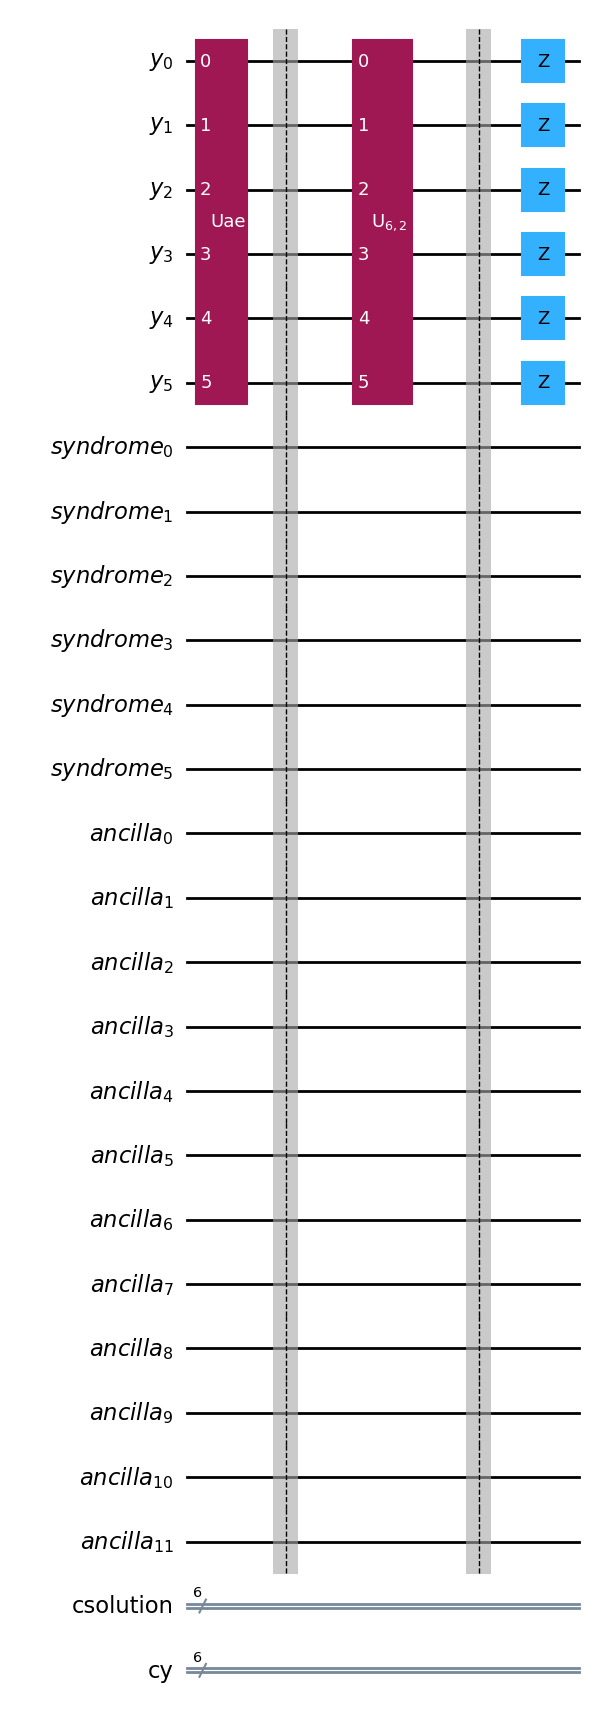

In [173]:
dqi_circuit.barrier()
dqi_circuit.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
display(dqi_circuit.draw('mpl'))

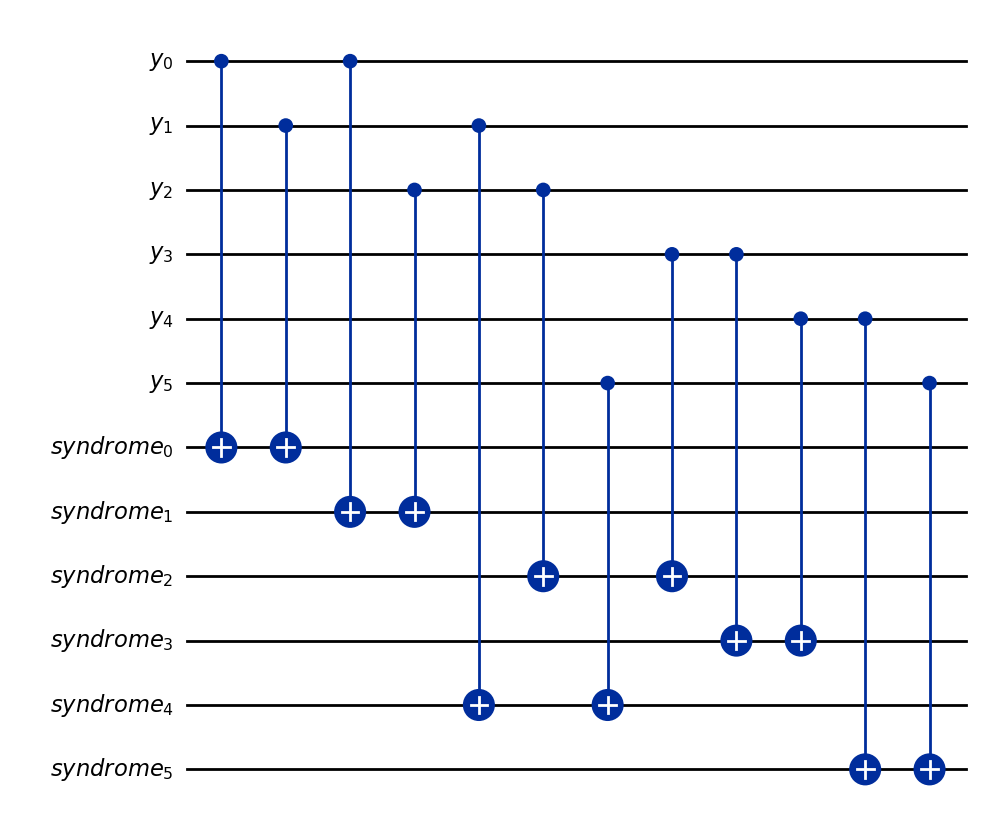

In [174]:
# Encode the constraint matrix B using CNOT gates
B_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs)
for i in range(n):
    for j in range(m):
        if B.T[i][j] == 1:
            B_circuit.cx(j, m+i)
display(B_circuit.draw('mpl'))

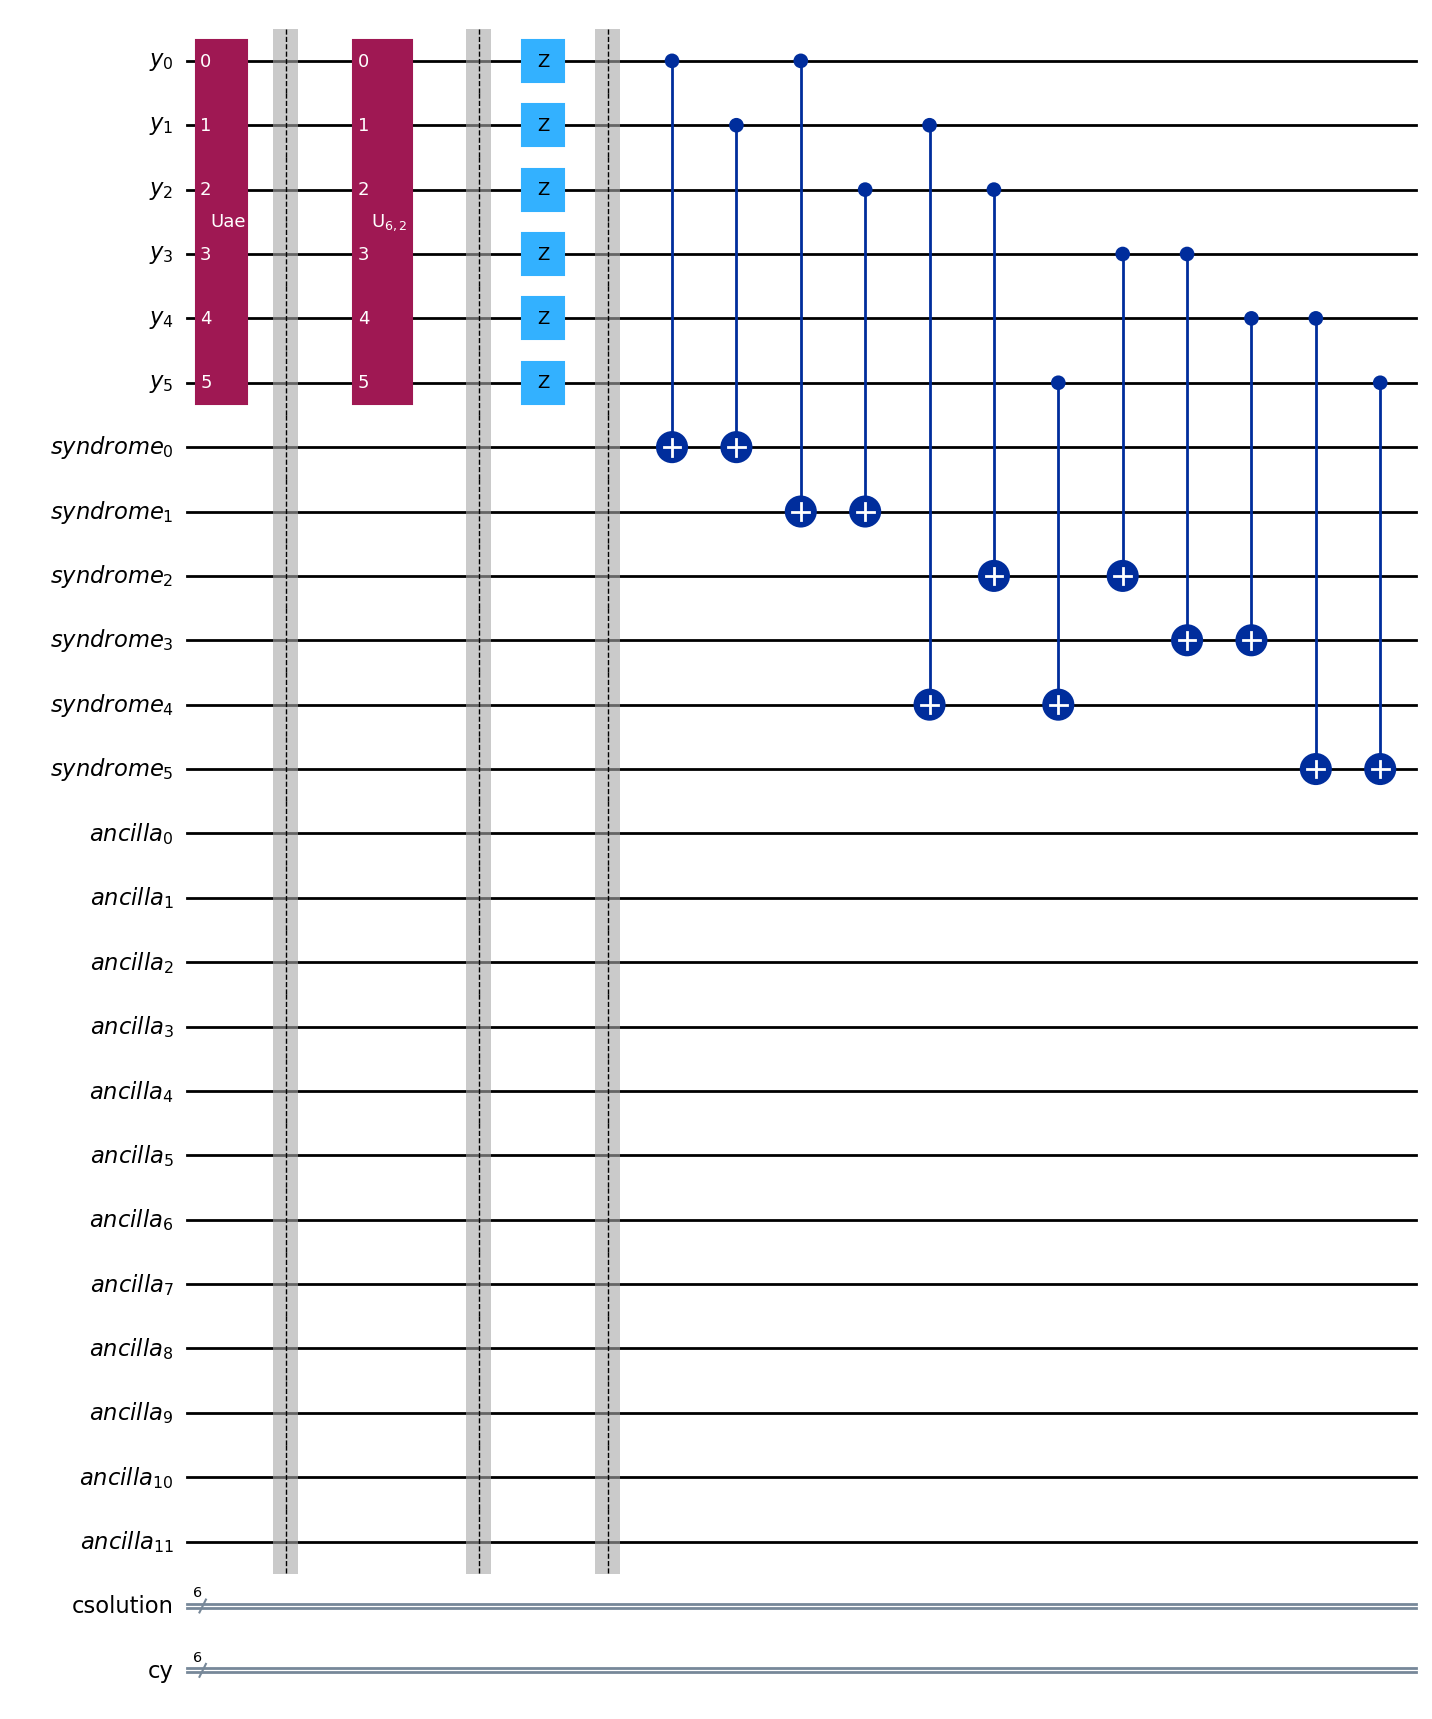

In [175]:
dqi_circuit.barrier()
dqi_circuit.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
display(dqi_circuit.draw('mpl'))

# Visualize the reduced state (if desired)
if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m))
    Statevector(np.diagonal(reduced_density_matrix)).draw('latex')



In [176]:
dqi_circuit_copy = dqi_circuit.copy()
dqi_circuit_copy.compose(qc_decode, qubits=list(range(dicke_qregs.size, qc_decode.num_qubits)) + list(range(dicke_qregs.size))
                         , inplace=True)

In [177]:
for i in range(n):
    dqi_circuit_copy.h(m+i)
    
# Measurement
dqi_circuit_copy.barrier()
dqi_circuit_copy.measure(dicke_qregs, dicke_cregs)
dqi_circuit_copy.measure(syndrome_qregs[::-1], syndrome_cregs)

In [178]:
simulator = AerSimulator()
transpiled_circuit = transpile(dqi_circuit_copy, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_circuit_copy)
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sorted_counts

{'111111 010110': 5260,
 '000000 010110': 5185,
 '000000 101001': 5156,
 '111111 101001': 5123,
 '000000 110100': 910,
 '000000 110110': 906,
 '111111 001110': 903,
 '111111 111001': 896,
 '111111 001011': 893,
 '111111 110001': 893,
 '111111 001010': 880,
 '111111 001001': 879,
 '000000 111001': 878,
 '000000 001011': 874,
 '111111 000110': 869,
 '000000 001001': 869,
 '000000 001110': 867,
 '000000 000110': 862,
 '111111 110100': 858,
 '000000 001010': 844,
 '111111 110110': 837,
 '000000 110001': 837,
 '000000 110101': 834,
 '111111 110101': 831,
 '111111 100001': 805,
 '000000 100001': 795,
 '000000 011110': 792,
 '111111 011110': 772,
 '000000 011001': 764,
 '111111 010001': 761,
 '000000 011011': 761,
 '111111 011001': 759,
 '000000 100100': 758,
 '000000 100110': 757,
 '111111 010011': 747,
 '111111 100101': 746,
 '000000 101110': 746,
 '000000 010001': 745,
 '111111 100110': 744,
 '111111 011010': 737,
 '111111 100100': 726,
 '111111 011011': 725,
 '111111 101100': 723,
 '00000

In [179]:
plot_results_union_plotly(
    brute_force_results,
    counts,
    plot_name="Comparison of DQI Results with True Objective Values",
    spline_smoothing=1.3
)


In [180]:
counts_filtered = post_selection_counts(counts)
plot_results_union_plotly(
    brute_force_results,
    counts_filtered,
    plot_name="Comparison of DQI Results with True Objective Values (Post-selected on |0⟩)",
    spline_smoothing=1.3
)


In [181]:
combined_counts = combine_counts(counts)
plot_results_union_plotly(
    brute_force_results,
    combined_counts,
    plot_name="Comparison of DQI Result and True Objective Values (Combined)",
    spline_smoothing=1.3
)
